# Import

## Modules

In [13]:
%load_ext autoreload
%autoreload 2

import sys
from datetime import timedelta, datetime
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


Setup figure plot settings

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
sns.set_palette("deep")

 Setup paths to import scripts

In [4]:
PROJECT_ROOT = Path.cwd().parent.resolve()
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [55]:
from src.data.make_dataset import make_cases_training_data, make_train_test_split, get_prior_distr_params

## Data

In [8]:
data = make_cases_training_data()

## Audit

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   notification_date       51 non-null     datetime64[ns]
 1   Daily Number of Cases   51 non-null     int64         
 2   Cumsum                  51 non-null     int64         
 3   Daily Difference        50 non-null     float64       
 4   Growth Factor           49 non-null     float64       
 5   Weekly Rolling Average  45 non-null     float64       
 6   Pct Change              44 non-null     float64       
 7   Weekly Average CumSum   45 non-null     float64       
 8   Epidemiological Days    51 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 6.0 KB


In [11]:
data

,notification_date,Daily Number of Cases,Cumsum,Daily Difference,Growth Factor,Weekly Rolling Average,Pct Change,Weekly Average CumSum,Epidemiological Days
0,2021-06-16,3,3,NaN,NaN,NaN,NaN,NaN,-24.0
1,2021-06-17,1,4,-2.0,NaN,NaN,NaN,NaN,-23.0
2,2021-06-18,2,6,1.0,-0.500000,NaN,NaN,NaN,-22.0
3,2021-06-19,1,7,-1.0,-1.000000,NaN,NaN,NaN,-21.0
4,2021-06-20,2,9,1.0,-1.000000,NaN,NaN,NaN,-20.0
5,2021-06-21,5,14,3.0,3.000000,NaN,NaN,NaN,-19.0
6,2021-06-22,17,31,12.0,4.000000,4.0,NaN,4.0,-18.0
7,2021-06-23,12,43,-5.0,-0.416667,6.0,0.500000,10.0,-17.0
8,2021-06-24,21,64,9.0,-1.800000,9.0,0.500000,19.0,-16.0
9,2021-06-25,28,92,7.0,0.777778,12.0,0.333333,31.0,-15.0


# Split Data

In [90]:
train_size = 0.8
X_train, X_test, y_train, y_test = make_train_test_split(data, train_size=train_size)

Get prior distribution parameters

In [91]:
initial_number_of_cases, daily_number_of_cases_std, average_pct_change, std_pct_change = get_prior_distr_params(y_train)
print(f"Number of cases at the start of the time series: {initial_number_of_cases}")
print(f"Daily number of cases standard deviation: {daily_number_of_cases_std}")
print(f"Average percentage change: {average_pct_change}")
print(f"Standard deviation of percentage change: {std_pct_change}")

Number of cases at the start of the time series: 45.0
Daily number of cases standard deviation: 50.340338297074894
Average percentage change: 0.29990242175442894
Standard deviation of percentage change: 0.9832313613242336


# Model Training

## Train Model

In [92]:
# Create PyMC3 context manager
with pm.Model() as model:

    # Setup data for the model
    t = pm.Data("X", X_train)
    cases = pm.Data("y", y_train)

    # Intercept
    a = pm.Normal("a", mu=initial_number_of_cases, sigma=daily_number_of_cases_std)

    # Slope 
    b = pm.Normal("b", mu=average_pct_change, sigma=std_pct_change)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample(1000, tune=1000, cores=5, return_inferencedata=True)
    post_Pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [eps, b, a]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 12 seconds.


## Model Evaluation

In [108]:
# Update data reference.
pm.set_data({"X": X_test}, model=model)

# Generate posterior samples
post_pred_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

TypeError: ('Wrong number of dimensions: expected 2, got 1 with shape (6,).', 'Container name "X"')

Get test prediction datam

In [118]:
y_pred = np.mean(post_pred_test["cases"], axis=0)
y_std = np.std(post_pred_test["cases"], axis=0)

Define custom metrics for model performance evaluation

In [119]:
def point_set_distance(y_pred: np.ndarray, y_pred_std: np.ndarray, y_true: np.ndarray
                        ) -> np.ndarray:
    """Compute the point-to-set distance between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        np.ndarray: point-to-set distance: Numpy array.

    References:
        [1] https://math.stackexchange.com/questions/2099527/distance-between-a-point-and-a-set-or-closure-of-it
    """
    assert y_pred.shape == y_true.shape, "The shapes of the predicted and true values do not match."
    assert y_pred.shape == y_pred_std.shape, "The shapes of predicted and std values do not match."

    return np.where(y_pred - y_pred_std <= y_true <= y_pred + y_pred_std, 0
            ,min(abs(y_true - (y_pred + y_pred_std))
                ,abs(y_true - (y_pred - y_pred_std))
                )
            )


def mean_squared_relative_error(y_pred: np.ndarray, y_true: np.ndarray
                                ,distance: str=None, y_pred_std: np.ndarray=None
                                ) -> float:
    """Compute the mean squared relative error between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        distance (str, optional): Distance metric to use. Defaults to None.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        float: mean squared relative error: Numpy array. Mean squared relative error between the predicted and true values.

    References:
        [1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t
    """
    if distance == "point to set":
        d = point_set_distance(y_pred, y_pred_std, y_true)

    else:
        d = y_pred - y_true

    return (d**2/y_true**2).mean()


def relative_mean_squared_error(y_pred: np.ndarray, y_true: np.ndarray
                                ,distance: str=None, y_pred_std: np.ndarray=None
                                ) -> float:
    """Compute reative mean squared error between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        distance (str, optional): Distance metric to use. Defaults to None.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        float: Relative mean squared error between the predicted and true values.

    References:
        [1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t
    """

    if distance == "point to set":
        d = point_set_distance(y_pred, y_pred_std, y_true)

    else:
        d = y_pred - y_true

    return (d**2).mean()/(y_true**2).sum()



Calculate performance metrics

In [121]:
r2 = r2_score(y_pred, y_test)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmsre = np.sqrt(mean_squared_relative_error(y_pred, y_test))
rrmse = np.sqrt(relative_mean_squared_error(y_pred, y_test))
mae = mean_absolute_error(y_pred, y_test)
rmae = (abs(y_pred - y_test) / y_test).mean()
print(f"R2 = {r2}")
print(f"RMSE = {rmse}, RMSRE = {rmsre}, RRMSE = {rrmse}")
print(f"MAE = {mae}, RMAE = {rmae}")

R2 = 0.9752978727849576
RMSE = 10.883369637219438, RMSRE = 0.051910918367367755, RRMSE = 0.028928562421590063
MAE = 6.255392767214128, RMAE = 0.03505414121940354


Plot residuals

<AxesSubplot:>

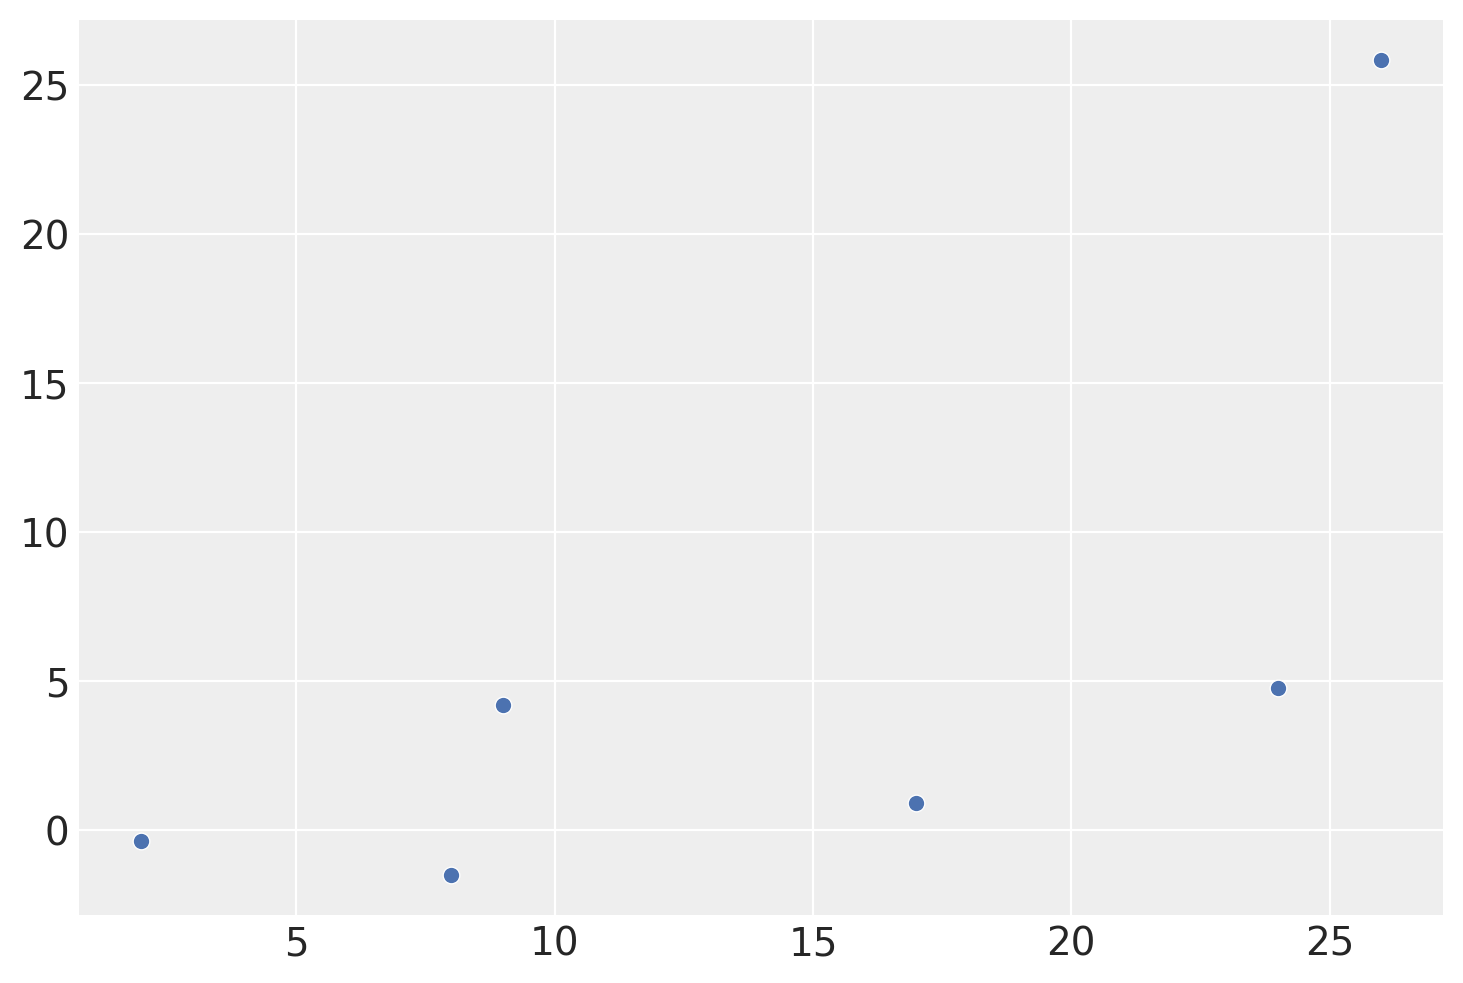

In [129]:
sns.scatterplot(x=X_test.squeeze(), y=(y_pred - y_test).squeeze(), marker="o")

# Model Inference

Distribution of model parameters

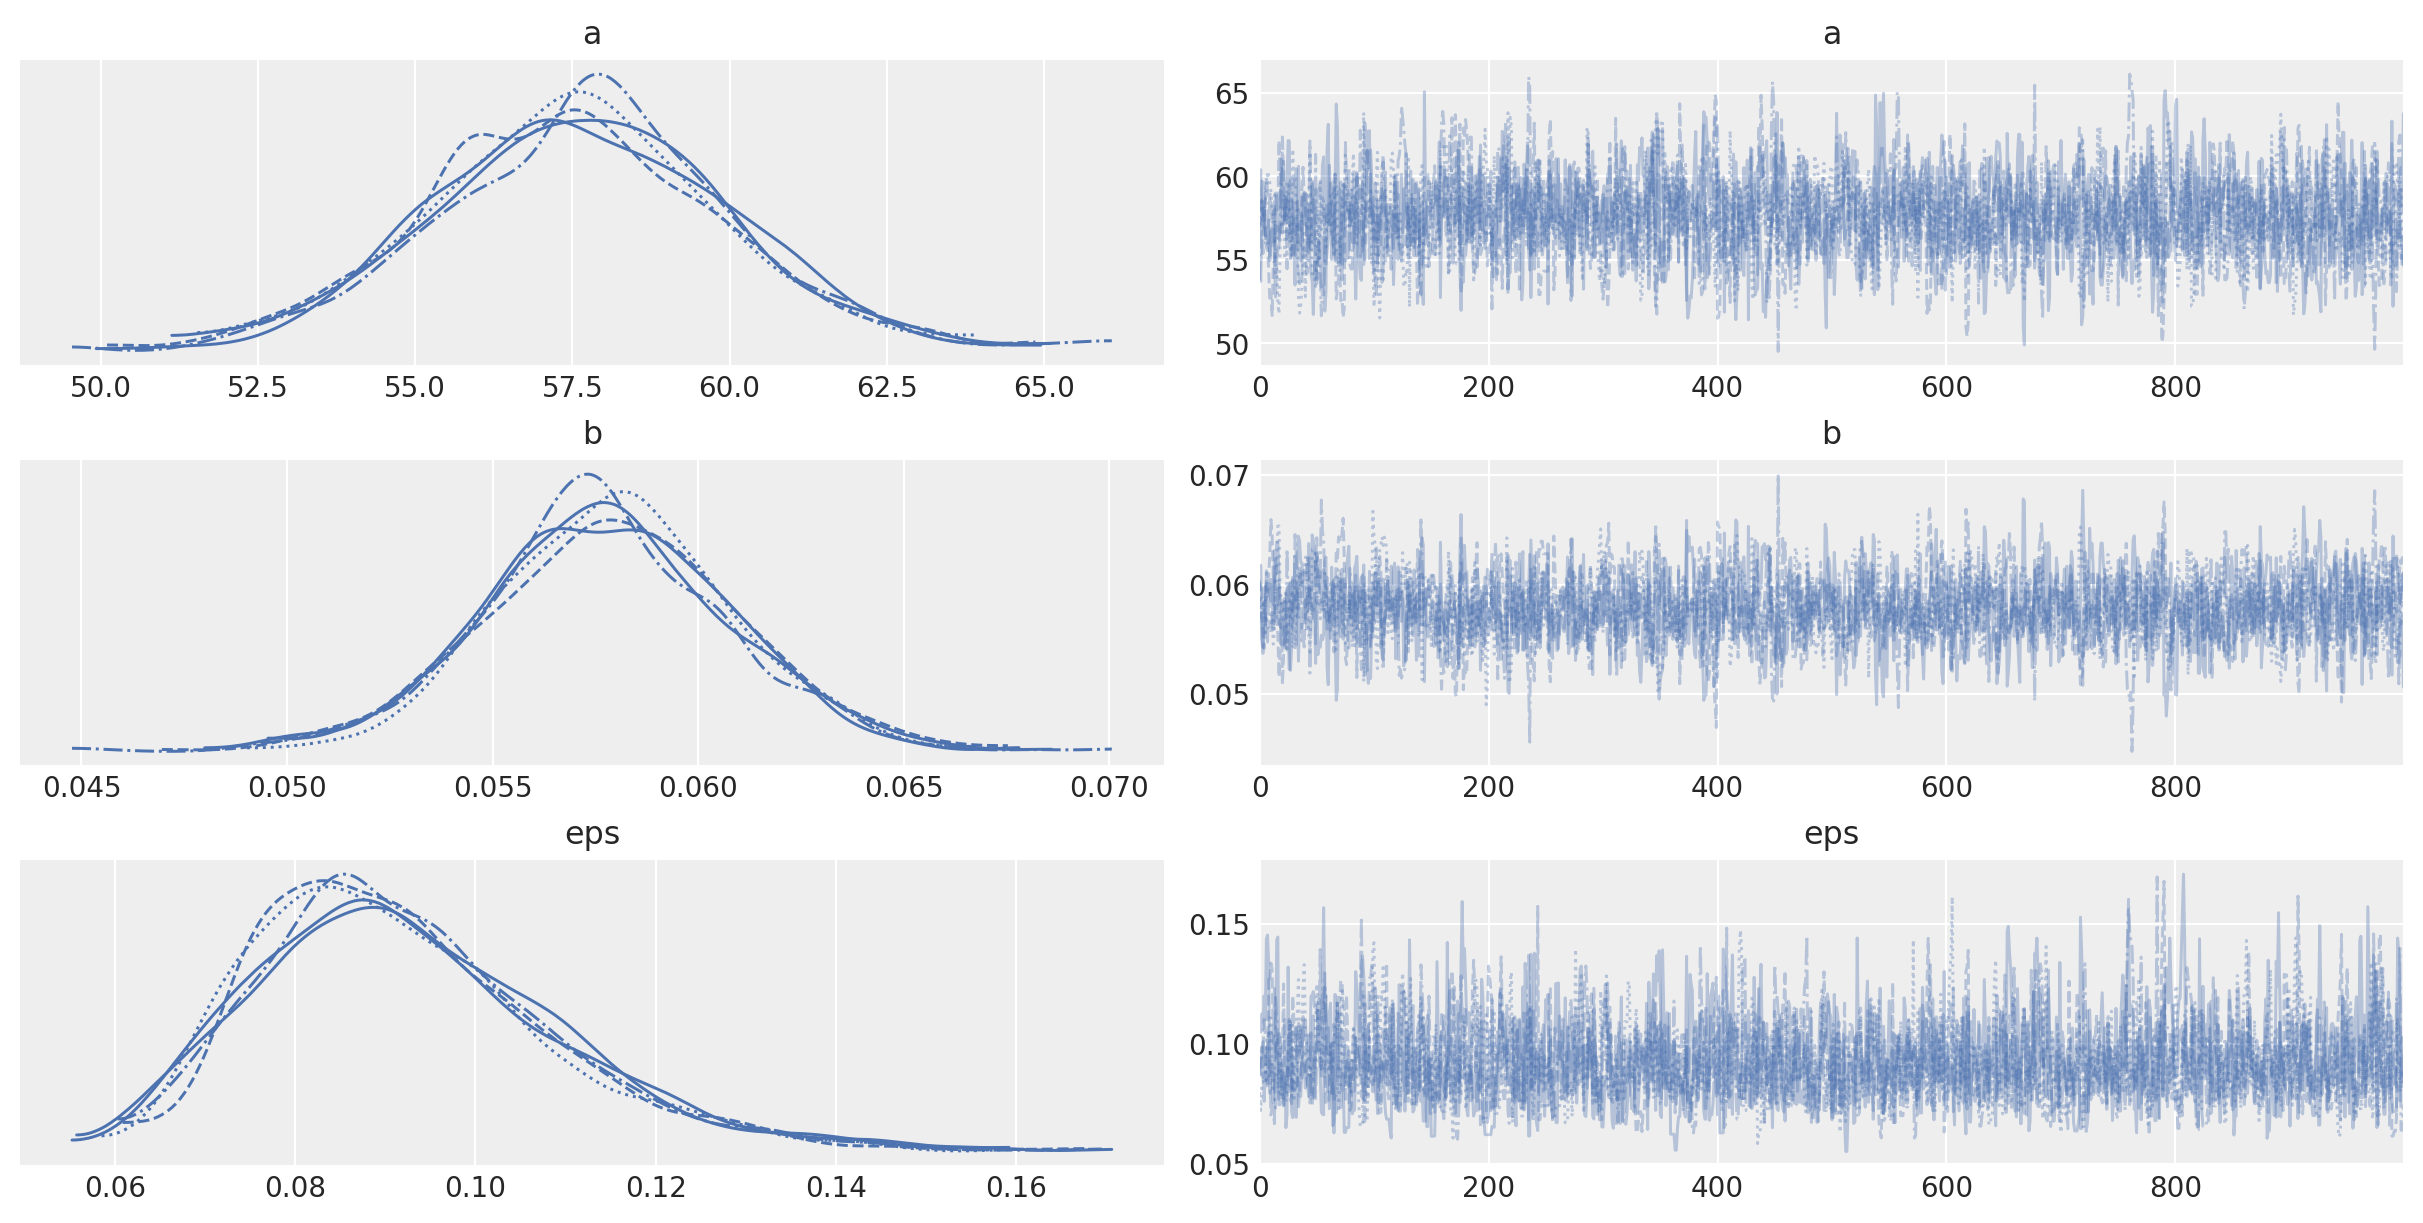

In [130]:
az.plot_trace(trace)
plt.show()

Summary of model parameters

In [131]:
pm.summary(trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,57.600,2.360,53.230,62.144,0.054,0.038,1920.0,2139.0,1.0
b,0.058,0.003,0.052,0.064,0.000,0.000,1899.0,1897.0,1.0
eps,0.092,0.016,0.065,0.124,0.000,0.000,1902.0,1509.0,1.0


## Predict on Whole Data Set

In [149]:
# Update data reference
X = np.sort(np.concatenate([X_train, X_test]).squeeze()).reshape(-1, 1)
pm.set_data({"X": X}, model=model)

# Generate posterior samples
post_pred = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Plot model posterior predictive and actual weekly rolling average for positive values of epidemiological days

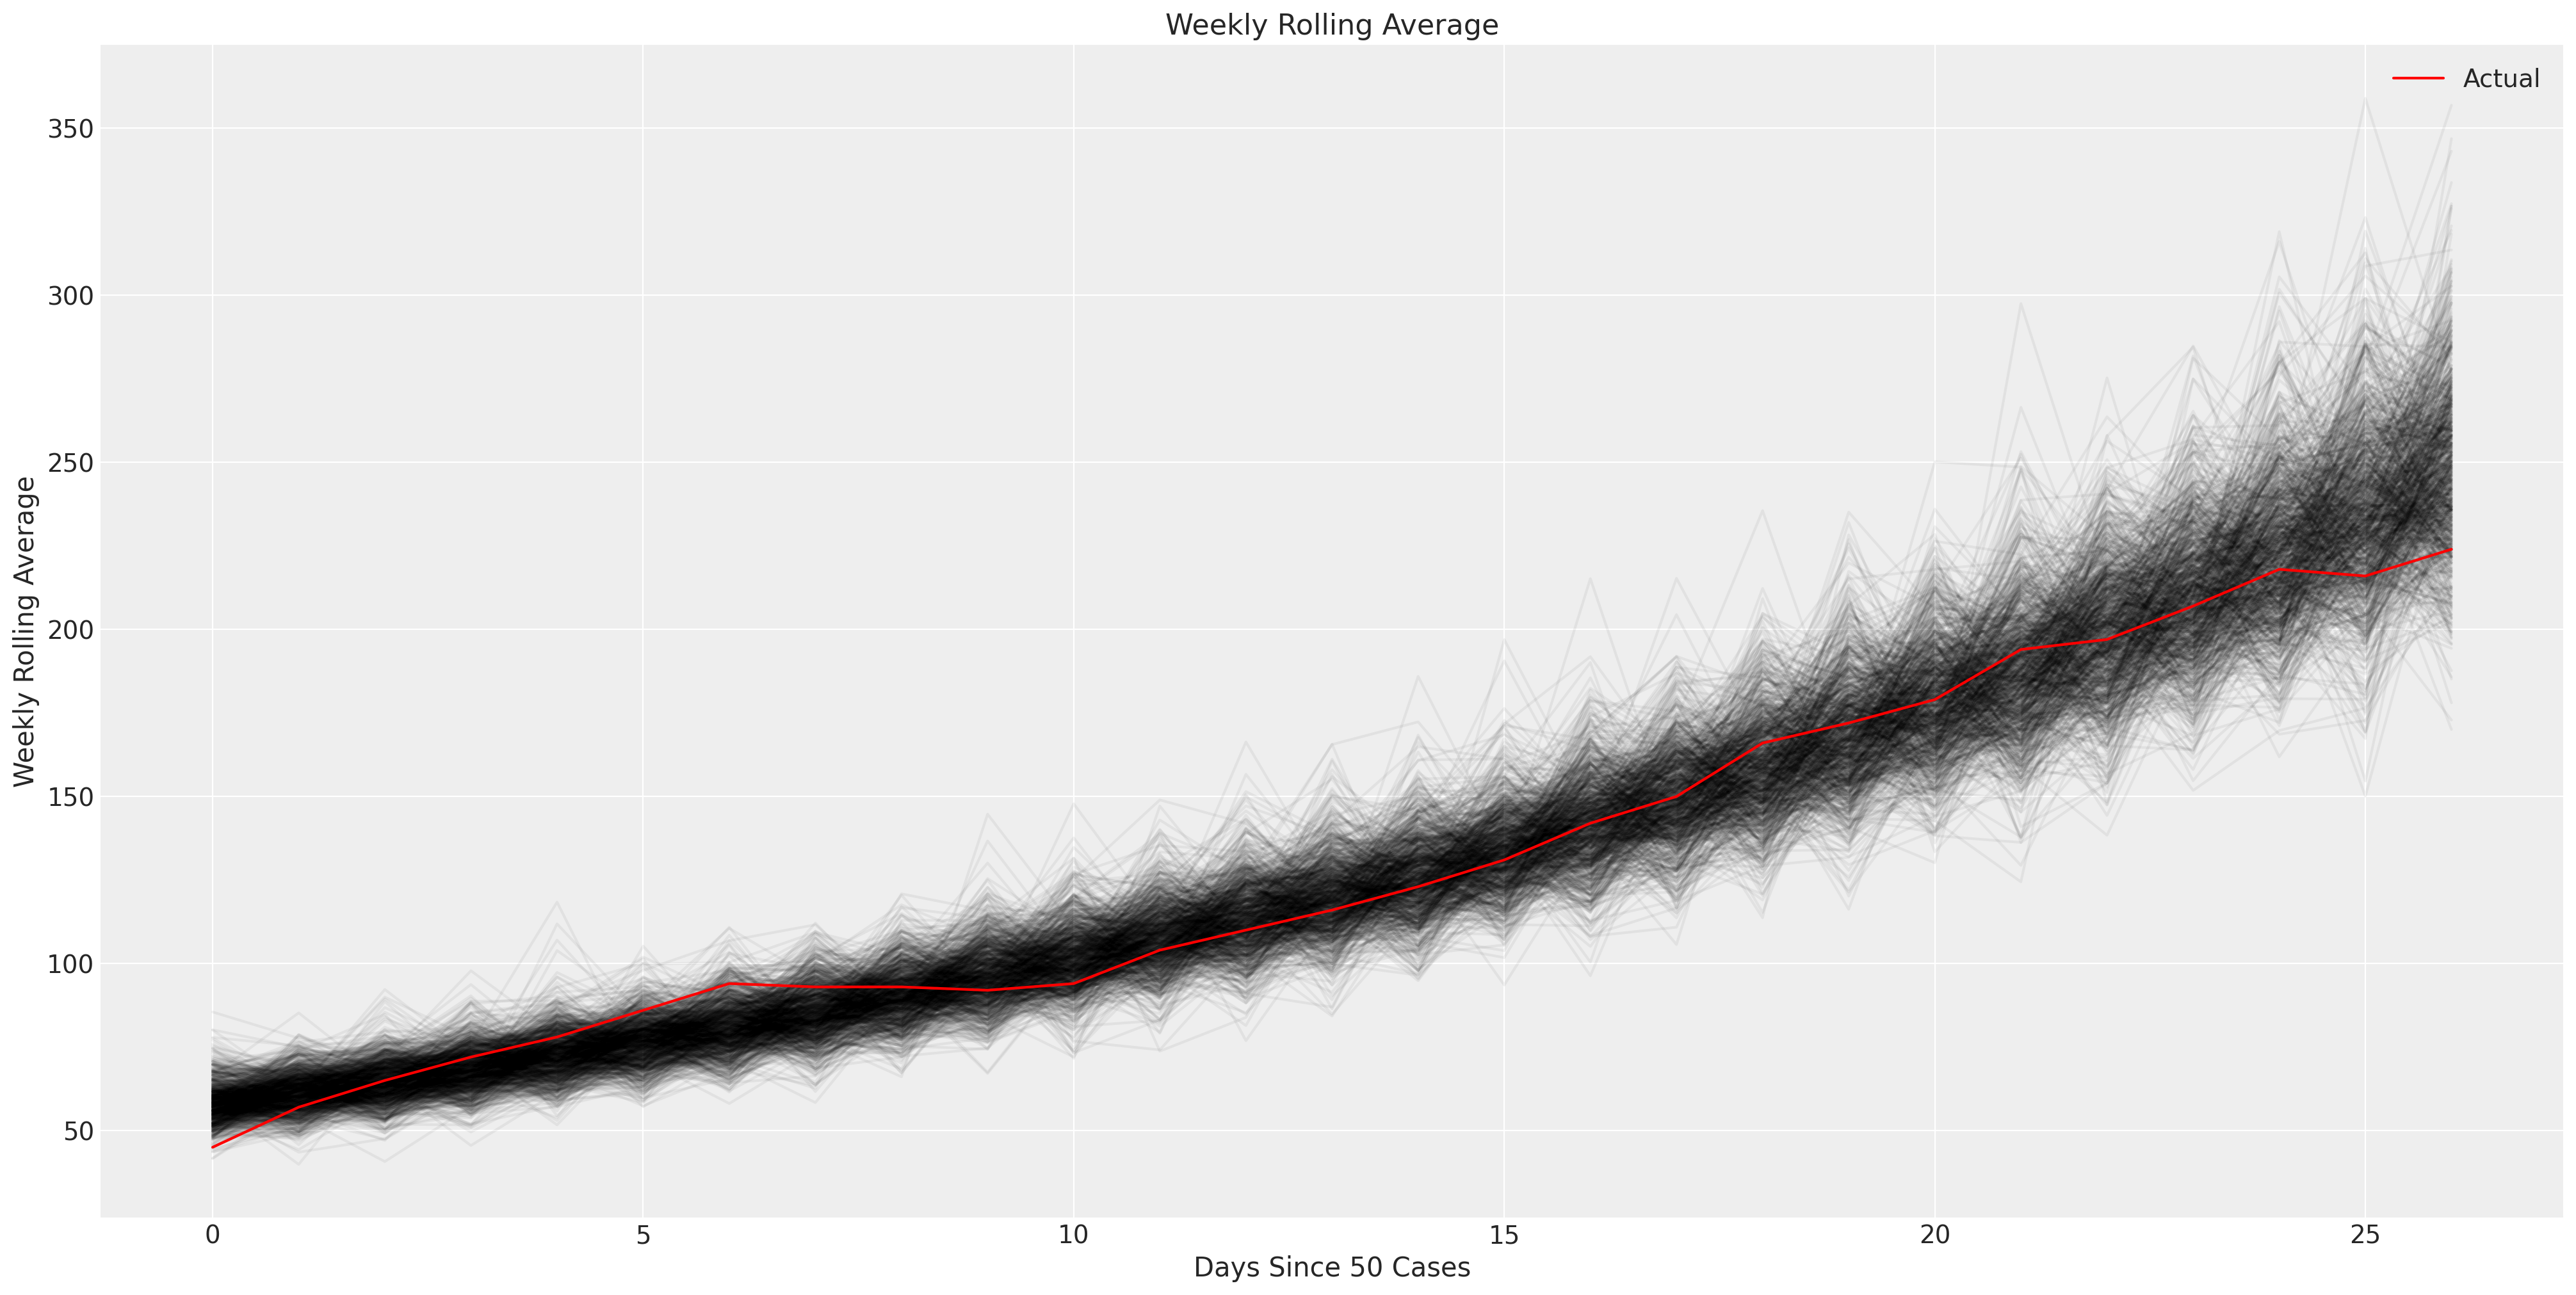

In [150]:
mask = data['Epidemiological Days'] >= 0

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X, post_pred["cases"].T[0, :, :], color="k", alpha=0.05)
ax.plot(X, data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
ax.set(xlabel="Days Since 50 Cases", ylabel="Weekly Rolling Average", title="Weekly Rolling Average")
ax.legend()

# Seven Days Forecast

In [153]:
# Augment epidemioligical days
forecast_ndays = 7
X_forecast = np.append(X, list(np.arange(X.max() + 1, X.max() + forecast_ndays + 1))).reshape(-1, 1)

# Update data reference.
pm.set_data({"X": X_forecast}, model=model)

# Generate posterior samples
post_pred_forecast = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Create data set containing forecast data

In [173]:
mask = data["Epidemiological Days"] >= 0
data_forecast = pd.DataFrame({"Epidemiological Days": X_forecast.flatten()
                            ,"Weekly Rolling Average": data.loc[mask, "Weekly Rolling Average"].append(pd.Series([np.nan]*forecast_ndays))
                            ,"Predicted Weekly Rolling Average": np.mean(post_pred_forecast["cases"], axis=0).flatten()
                            ,"notification_date": data.loc[mask, "notification_date"].append(pd.Series([data["notification_date"].max() + timedelta(days=day) for day in range(1, forecast_ndays+1)]))
                            ,"Predicted Weekly Rolling Std": np.std(post_pred_forecast["cases"], axis=0).flatten()
                            })
data_forecast.reset_index(inplace=True, drop=True)
data_forecast["Prediction Lower Bound"] = data_forecast["Predicted Weekly Rolling Average"] - data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Prediction Upper Bound"] = data_forecast["Predicted Weekly Rolling Average"] + data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Forecast_On_Date"] = datetime.now().date()
data_forecast[["Predicted Weekly Rolling Average", "Prediction Lower Bound", "Prediction Upper Bound", "Forecast_On_Date", "notification_date"]].to_csv(str(PROJECT_ROOT / "data" / "processed" / f"predicted_weekly_rolling_average_{datetime.now().date()}.csv"), index=False)
data_forecast

,Epidemiological Days,Weekly Rolling Average,Predicted Weekly Rolling Average,notification_date,Predicted Weekly Rolling Std,Prediction Lower Bound,Prediction Upper Bound,Forecast_On_Date
0,0.0,45.0,57.885166,2021-07-10,5.722524,52.162642,63.607690,2021-08-06
1,1.0,57.0,60.980617,2021-07-11,6.206578,54.774039,67.187195,2021-08-06
2,2.0,65.0,64.846542,2021-07-12,6.592527,58.254015,71.439069,2021-08-06
3,3.0,72.0,68.403306,2021-07-13,6.791501,61.611805,75.194807,2021-08-06
4,4.0,78.0,72.458806,2021-07-14,7.335418,65.123388,79.794225,2021-08-06
5,5.0,86.0,76.776489,2021-07-15,7.450960,69.325528,84.227449,2021-08-06
6,6.0,94.0,80.781956,2021-07-16,8.113688,72.668268,88.895644,2021-08-06
7,7.0,93.0,86.006603,2021-07-17,8.588681,77.417921,94.595284,2021-08-06
8,8.0,93.0,91.195289,2021-07-18,8.396535,82.798754,99.591824,2021-08-06
9,9.0,92.0,95.824398,2021-07-19,9.297041,86.527357,105.121439,2021-08-06


Plot actual and forecasted values

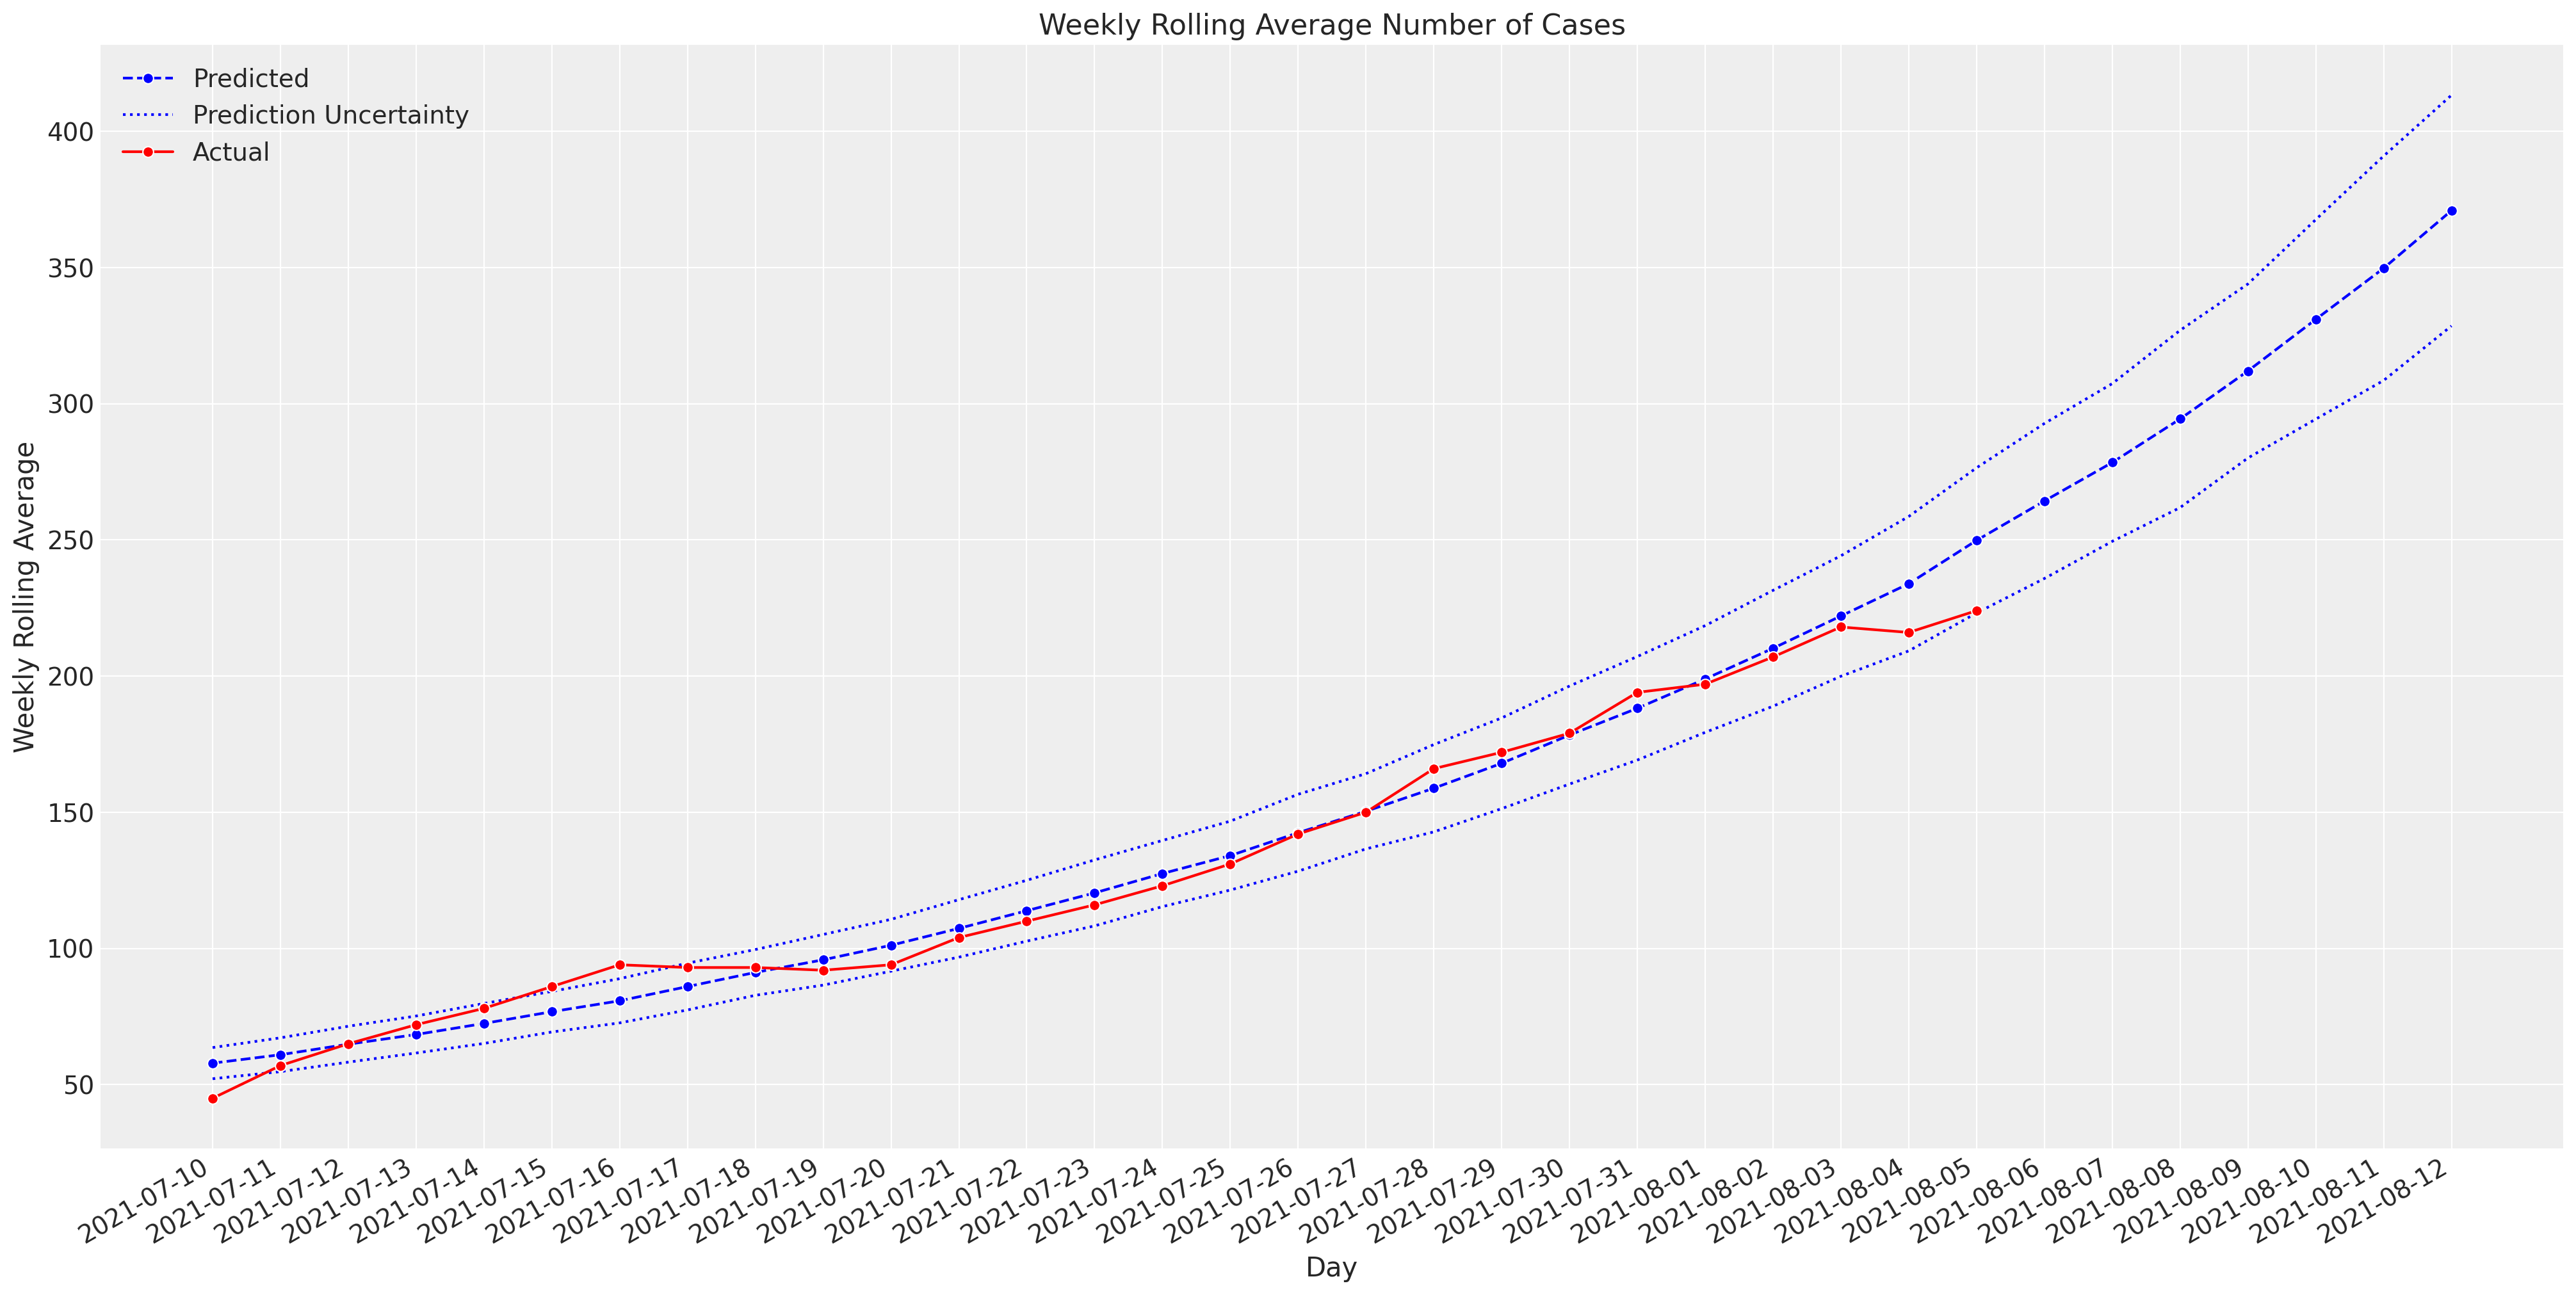

In [176]:
forecast_std = np.std(post_pred_forecast["cases"], axis=0).flatten()

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"], axis=0).flatten(), color="b", marker="o", label="Predicted", linestyle="--", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"], axis=0).flatten() + forecast_std.flatten(), color="b", linestyle=":", label="Prediction Uncertainty", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"], axis=0).flatten() - forecast_std.flatten(), color="b", linestyle=":", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=data_forecast["Weekly Rolling Average"], color="r", label="Actual", marker="o", ax=ax)

plt.xticks(data_forecast["Epidemiological Days"], data_forecast["notification_date"].astype(str), rotation = 30, ha="right")

ax.set(xlabel="Day", ylabel="Weekly Rolling Average", title="Weekly Rolling Average Number of Cases")
ax.legend()
ax.grid(True)

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Aug 04 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.25.0

pandas    : 1.3.0
matplotlib: 3.4.2
seaborn   : 0.11.1
pymc3     : 3.11.2
sys       : 3.9.2 (default, Mar 12 2021, 19:04:51) 
[GCC 8.3.0]
arviz     : 0.11.2
numpy     : 1.19.5

Watermark: 2.2.0

